Fine-tune bert: https://skimai.com/fine-tuning-bert-for-sentiment-analysis/

In [64]:
import re
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
from unidecode import unidecode
from flair.data import Sentence
from flair.models import SequenceTagger
from flair.models import TextClassifier
from rich import print
from nltk.tokenize import sent_tokenize

import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')

%matplotlib inline

def extract_names(docs, save=False):
    results = []
    
    for doc in docs:
        
        # split doc in sentences
        sentences = sent_tokenize(doc)
#         sentences = [e + "." for e in doc.split(".") if e]
        
        for sent in sentences:
            
            sentence = Sentence(sent, use_tokenizer=True)
            tagger.predict(sentence)

            for entity in sentence.get_spans('ner'):
                
                # Extract person and predict sentiment if person is in sentence
                if entity.tag == "PER":
                    classifier.predict(sentence)
                    score = sentence.get_labels()[0].score
                    value = sentence.get_labels()[0].value
                    name = entity.text
                    results.append((name, score, value))

    if save:
        with open(f'../data/{save}_names.json', 'w') as f:
            json.dump(results, f)
                
    return results


def extract_df(name_list):
    df = pd.DataFrame(name_list, columns=["Word", "Prob", "Sentiment"])
    df.Sentiment = df.Sentiment.map({"POSITIVE": 1, "NEGATIVE": -1})
    df.Word = df.Word.astype(str)
    df = preprocess_counts(df)
    return df


def preprocess_counts(df):
    """ Preprocess the data
    
    * Combine names such as Miguel and Miguel's by removing everything next to the special character 
    
    """
    # Remove accents
    df.Word = [unidecode(word) for word in df.Word]
    
    # Combine names such as Miguel and Miguel's by removing everything next to the special character
#     df.Word = df.Word.str.replace('[^A-z]',' ').str.strip().str.split(' ').str[0]  
    df.Word = df.Word.str.replace('[^A-z]',' ').str.strip()
    df = df.groupby("Word").agg({"Sentiment": [np.mean, np.count_nonzero]})
    df.columns = df.columns.droplevel()
    df = df.reset_index()
    df.columns = ["Word", "Sentiment", "Count"]
    df = df.sort_values("Count", ascending=False)
    
    # Remove names less than 3 characters
    df = df.loc[df.Word.str.len() >= 3, :]
    
    # Remove the "name" Disney
    df = df.loc[df.Word != "Disney", :]
    
    return df

def predict(title, name, reviews):
    print(title)
    new_docs = [sent_tokenize(doc) for doc in reviews]
    new_docs = [x for sublist in new_docs for x in sublist]
    total_length = sum([len(x) for x in new_docs])
    new_docs = [Sentence(x) for x in new_docs]
    
    tagger.predict(new_docs, verbose=True)
    classifier.predict(new_docs, verbose=True)

    results = []
    for sentence in new_docs:
        for token in sentence.get_spans('ner'):
            if token.tag == "PER":
                results.append((token.text, sentence.get_labels()[0].score, sentence.get_labels()[0].value))
                
    with open(f'../data/{name}.json', 'w') as f:
        json.dump(results, f)
    return results

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maarten\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Load Model**  
This model was trained over the English CoNLL-03 task and can recognize 4 different entity types.

In [6]:
tagger = SequenceTagger.load('ner-fast')  # ner-fast for cpu-based predictions
classifier = TextClassifier.load('sentiment-fast')

2020-08-13 08:03:10,951 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/models-v0.4/NER-conll03--h256-l1-b32-p3-0.5-%2Bglove%2Bnews-forward-fast%2Bnews-backward-fast-normal-locked0.5-word0.05--release_4/en-ner-fast-conll03-v0.4.pt not found in cache, downloading to C:\Users\Maarten\AppData\Local\Temp\tmpqgfq7cox


100%|████████████████████████████████████████████████████████████████| 256774339/256774339 [01:51<00:00, 2296128.43B/s]


2020-08-13 08:05:03,293 copying C:\Users\Maarten\AppData\Local\Temp\tmpqgfq7cox to cache at C:\Users\Maarten\.flair\models\en-ner-fast-conll03-v0.4.pt
2020-08-13 08:05:04,074 removing temp file C:\Users\Maarten\AppData\Local\Temp\tmpqgfq7cox
2020-08-13 08:05:04,121 loading file C:\Users\Maarten\.flair\models\en-ner-fast-conll03-v0.4.pt
2020-08-13 08:05:07,555 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-fasttext-rnn/sentiment-en-mix-ft-rnn.pt not found in cache, downloading to C:\Users\Maarten\AppData\Local\Temp\tmpinys5zey


100%|██████████████████████████████████████████████████████████████| 1242007042/1242007042 [05:52<00:00, 3525074.82B/s]


2020-08-13 08:11:00,119 copying C:\Users\Maarten\AppData\Local\Temp\tmpinys5zey to cache at C:\Users\Maarten\.flair\models\sentiment-en-mix-ft-rnn.pt
2020-08-13 08:11:13,802 removing temp file C:\Users\Maarten\AppData\Local\Temp\tmpinys5zey
2020-08-13 08:11:14,013 loading file C:\Users\Maarten\.flair\models\sentiment-en-mix-ft-rnn.pt


**Load Data**

In [45]:
with open('../data/disney_reviews.json') as f:
    reviews = json.load(f)

# docs = reviews['Frozen']

In [56]:
titles = [(title, re.sub('[^a-zA-Z]+', '', title).lower()) for title in list(reviews.keys())]

In [66]:
# results = predict("Moana", "moana", reviews["Moana"])

**Generate Predictions**

In [35]:
new_docs = [sent_tokenize(doc) for doc in docs]
new_docs = [x for sublist in new_docs for x in sublist]
total_length = sum([len(x) for x in new_docs])
new_docs = [Sentence(x) for x in new_docs]

In [36]:
tagger.predict(new_docs, verbose=True)
classifier.predict(new_docs, verbose=True)

results = []
for sentence in new_docs:
    for token in sentence.get_spans('ner'):
        if token.tag == "PER":
            results.append((token.text, sentence.get_labels()[0].score, sentence.get_labels()[0].value))

Inferencing on batch 541: 100%|██████████████████████████████████████████████████████| 541/541 [00:18<00:00, 28.60it/s]


In [60]:
with open('../data/test.json', 'w') as f:
    json.dump(results, f)

In [42]:
df = pd.DataFrame(results, columns=["Word", "Prob", "Sentiment"])

# Preprocessing
df.Sentiment = df.Sentiment.map({"POSITIVE": 1, "NEGATIVE": -1})
df.Word = [unidecode(word) for word in df.Word]
df.Word = df.Word.str.replace('[^A-z]',' ').str.strip()
df.Word = [re.sub(r"\b[a-zA-Z]\b", "", word).strip() for word in df.Word.values]
df = df.loc[df.Word != "Disney", :]
df = df.loc[df.Word.str.len() >= 3, :]
df = df.loc[df.Prob > 0.9, :]

# # Finishing up
df = df.groupby("Word").agg({"Sentiment": [np.mean, np.count_nonzero]})
df.columns = df.columns.droplevel()
df = df.reset_index()
df.columns = ["Word", "Sentiment", "Count"]
df = df.sort_values("Count", ascending=False)

**Visualize Results**  

Fix: 
* Miguel's
* ,Miguel
* Tom Hanks


**Preprocess Predictions**

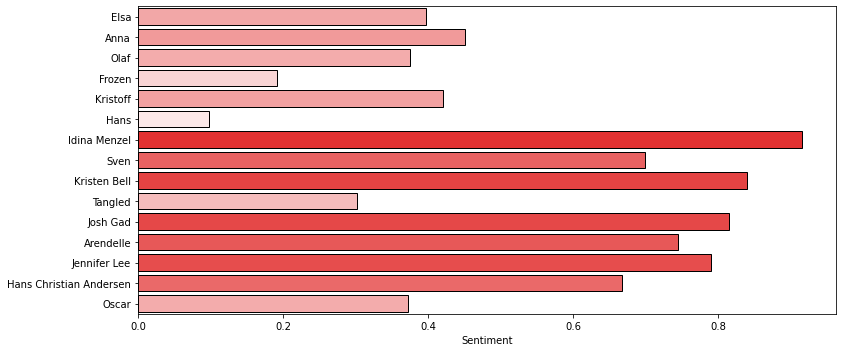

In [43]:
plt.figure(figsize=(12, 5))
norm = TwoSlopeNorm(vmin=-1, vcenter=0.0, 
                    vmax=1)
colors = [plt.cm.bwr(norm(c)) for c in df.Sentiment.head(15)]
ax = sns.barplot(x='Sentiment', y='Word', data=df.head(15), palette=colors, edgecolor='black')
plt.tight_layout()
plt.xlabel("Sentiment")
plt.ylabel("")
plt.show()
# plt.savefig("../images/frozen.png", dpi=300)